<a href="https://colab.research.google.com/github/CIS-522/course-content/blob/week11_feedback/tutorials/W11_DeepRL/W11_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 12 Part 1
# Introduction to Reinforcement Learning

__Instructor:__ Dinesh Jayaraman

__Content creators:__ Chuning Zhu



---

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = '' #@param {type:"string"}
my_pod = 'Select' #@param ['Select', 'upain', 'ah-damn-optimizer', 'backpropagandists', 'backpropers','excel-erators','GAN-gsters','han-not-solo','hufflefluffs','lets-taco-bout-it','natural-networkers','pytorture','sigmoids','strong-signals','the-denominators','the-travellers', 'the-weekenders', 'tomorrows-incredibles', 'brute-force']
my_email = '' #@param {type:"string"}
tutorial = 'W12D1'

# start timing
import time
try:t0;
except NameError: t0 = time.time()

---
# Setup

In [ ]:
# imports

import math
import numpy as np
import IPython
from numbers import Number
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm

In [ ]:
# @title Plotting functions
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

# Plotting functions
def plot_episode_rewards(episode_rewards):
    fig = plt.figure()
    plt.plot(episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    fig.show()

In [ ]:
# @title Gridworld Environment

'''
    A custom Gridworld environment with deterministic transitions. Adapted from 
    CS 188 Gridworld env. There are four actions: up, left, down, right. The 
    state is the (x, y) coordinates in the Grid. 
'''
class Gridworld():
    
    def __init__(self, grid, living_reward=-1.0):
        self.h = len(grid)
        self.w = len(grid[0])
        self.living_reward = living_reward
        
        self.scale = math.ceil(max(self.h, self.w) / min(self.h, self.w))
        self.action_space = ['up', 'left', 'down', 'right']
        self.n_actions = 4

        self.init_grid(grid)

    def init_grid(self, grid):
        # Create reward grid. The reward grid is a numpy array storing the
        # reward given for entering each state.
        self.rew_grid = np.array([[self.living_reward if isinstance(e, str) else e 
                                   for e in row] for row in grid], dtype=np.float)

        # Create grid. The grid is a numpy of chars. 
        # S (start), T (terminal), C (cliff), # (block), or ' ' (regular).
        convert_fn = lambda e: 'T' if e >= self.living_reward else 'C'
        self.grid = np.array([[convert_fn(e) if isinstance(e, Number) else e 
                               for e in row] for row in grid])
        
        # Find initial state
        start_indices = np.argwhere(self.grid == 'S')
        if len(start_indices) == 0:
            raise Exception('Grid has no start state')
        self.init_state = (start_indices[0][1], start_indices[0][0])

        
    def get_transition(self, state, action):
        '''
        Execute one action in the environment.
        Args:
            state (tuple): the (x, y) coordinates of the current state.
            action (int): the current action chosen from {0, 1, 2, 3}.

        Returns:
            next_state (tuple): the (x, y) coordinates of the next state.
            reward (float): the reward for the current time step.
        '''
        # Handle terminal states
        x, y = state
        if self.grid[y, x] == 'T':
            return state, 0
        
        # Handle invalid actions
        if action not in range(len(self.action_space)):
            raise Exception('Illegal action')

        # Default transitions
        named_action = self.action_space[action]
        nx, ny = x, y
        if named_action == 'up':
            ny -= 1
        elif named_action == 'left':
            nx -= 1
        elif named_action == 'down':
            ny += 1 
        elif named_action == 'right':
            nx += 1

        # Handle special cases
        if nx < 0 or nx >= self.w or ny < 0 or ny >= self.h or self.grid[ny, nx] == '#':
            # Give living reward if next state is blocked or out of bounds
            reward = self.living_reward
            next_state = (x, y)
        else:
            reward = self.rew_grid[ny, nx]
            if self.grid[ny, nx] == 'C':
                next_state = self.init_state # falls off cliff
            else:
                next_state = (nx, ny) # transition to next state

        return next_state, reward

    def __render(self):
        # Render grid with matplotlib patches. 
        fig, ax = plt.subplots(figsize=(self.h*self.scale, self.w*self.scale))
        ax.set_aspect('equal')
        ax.set_xlim(0, self.w)
        ax.set_ylim(0, self.h)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)
        plt.axis('off')
        for y in range(self.h):
            for x in range(self.w):
                cell_type = self.grid[y, x]
                if cell_type == 'S':
                    c = '#DAE8FC' # blue
                elif cell_type == '#':
                    c = '#CCCCCC' # gray
                elif cell_type == 'T':
                    c = '#D5E8D4' # green
                elif cell_type == 'C':
                    c = '#F8CECC' # red
                else:
                    c = '#FFFFFF' # white
                rect = patches.Rectangle((x, self.h-y-1), 1, 1, fc=c, ec='gray', lw=1)
                ax.add_patch(rect)
        return fig, ax

    def render_grid(self):
        fig, ax = self.__render()
        for y in range(self.h):
            for x in range(self.w):
                if self.grid[y, x] != '#':
                    # alternate: x+0.1, self.h-y-0.2
                    ax.text(x+0.5, self.h-y-0.5, str(self.rew_grid[y, x]), size='medium', ha='center', va='center')
        plt.title("Rewards")
        fig.show()
    
    def render_values(self, V):
        fig, ax = self.__render()
        for y in range(self.h):
            for x in range(self.w):
                ax.text(x+0.5, self.h-y-0.5, '{:.2f}'.format(V[y, x]), size='medium', ha='center', va='center')
        plt.title("Values")
        fig.show()

    def render_q_values(self, Q):
        fig, ax = self.__render()
        for y in range(self.h):
            for x in range(self.w):
                named_action = self.action_space[np.argmax(Q[y, x])]
                xl, xc, xr = x, x+0.5, x+1
                yt, yc, yb = self.h-y, self.h-y-0.5, self.h-y-1
                ce, tl, bl, tr, br = [xc, yc], [xl, yt], [xl, yb], [xr, yt], [xr, yb]
                if named_action == 'up':
                    xy = np.array([ce, tl, tr])
                elif named_action == 'left':
                    xy = np.array([ce, tl, bl])
                elif named_action == 'down':
                    xy = np.array([ce, bl, br])
                elif named_action == 'right':
                    xy = np.array([ce, br, tr])
                ax.plot([x, x+1], [self.h-y, self.h-y-1], 'gray', lw=1)
                ax.plot([x, x+1], [self.h-y-1, self.h-y], 'gray', lw=1)
                poly = patches.Polygon(xy, True, fc='#FFFF00', ec='gray')
                ax.add_patch(poly)
                ax.text(x+0.5, self.h-y-0.2, '{:.2f}'.format(Q[y, x, 0]), size='small', ha='center', va='center')
                ax.text(x+0.2, self.h-y-0.5, '{:.2f}'.format(Q[y, x, 1]), size='small', ha='center', va='center')
                ax.text(x+0.5, self.h-y-0.8, '{:.2f}'.format(Q[y, x, 2]), size='small', ha='center', va='center')
                ax.text(x+0.8, self.h-y-0.5, '{:.2f}'.format(Q[y, x, 3]), size='small', ha='center', va='center')
        fig.show()
        plt.title("Q-values")
        pass
    
    def render_policy(self, policy):
        fig, ax = self.__render()
        for y in range(self.h):
            for x in range(self.w):
                if policy[y, x] not in range(len(self.action_space)):
                    raise Exception('Illegal action')
                if self.grid[y, x] == 'T':
                    continue
                arrow_len = 0.3
                dx, dy = 0, 0
                named_action = self.action_space[policy[y, x]]
                if named_action == 'up':
                    dy = arrow_len
                elif named_action == 'left':
                    dx = -arrow_len
                elif named_action == 'down':
                    dy = -arrow_len
                elif named_action == 'right':
                    dx = arrow_len
                arrow = patches.FancyArrow(x+0.5, self.h-y-0.5, dx, dy, 0.03, True, color='#6C8EBF')
                ax.add_patch(arrow)
        plt.title("Policy")
        fig.show()


'''
    GridworldEnv is a wrapper around Gridworld implementing an RL interface.
'''
class GridworldEnv(Gridworld):
    def __init__(self, grid, living_reward=-1.0):
        super().__init__(grid, living_reward)
        self.reset()
        
    def reset(self):
        '''
        Reset the agent to its initial state
        '''
        self.state = self.init_state
        return self.state

    def step(self, action):
        '''
        Execute one action in the environment.
        Args:
            action (int): the current action chosen from {0, 1, 2, 3}.

        Returns:
            next_state (tuple): (x, y) coordinates of the next state.
            reward (float): reward for the current time step.
            done (bool): True if a terminal state has been reached, False otherwise.
        '''
        next_state, reward = self.get_transition(self.state, action)
        self.state = next_state
        done = self.grid[self.state[1], self.state[0]] == 'T'
        return next_state, reward, done

# Pre-defined grids
def get_book_grid():
    grid = [['T',  ' ',  ' ',  ' '],
            [' ',  ' ',  ' ',  ' '],
            [' ',  ' ',  ' ',  ' '], 
            ['S',  ' ',  ' ',  'T']]
    return GridworldEnv(grid)

def get_cliff_small():
    grid = [[' ',   ' ',  ' ',  ' ',  ' '],
            ['S',   ' ',  ' ',  ' ',   'T'],
            [-100, -100, -100, -100, -100]]
    return GridworldEnv(grid)

def get_cliff_walk():
    grid = [[' ' for _ in range(12)] for _ in range(3)]
    grid.append([-100 for _ in range(12)])
    grid[3][ 0] = 'S'
    grid[3][-1] = 'T'
    return GridworldEnv(grid)

def get_bridge_grid():
    grid = [[ '#',-100, -100, -100, -100, -100, '#'],
            [   1, 'S',  ' ',  ' ',  ' ',  ' ',  10],
            [ '#',-100, -100, -100, -100, -100, '#']]
    return GridworldEnv(grid)

---
# Section 1: Introduction


Video available at https://youtube.com/watch?v=cVTud58UfpQ


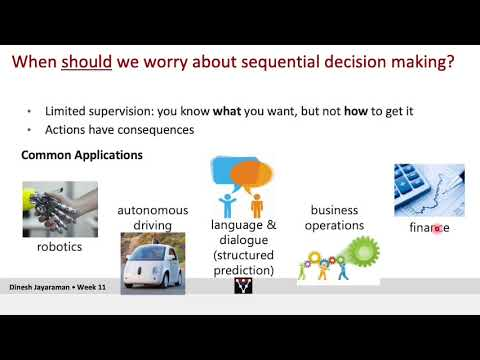

In [ ]:
#@title Video : Intro to Reinforcement Learning

import time
try: t0;
except NameError: t0=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="cVTud58UfpQ", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Up to this point, we have mainly been concerned with supervised learning. In a supervised learning problem, we are provided with a dataset where each sample comes with a ground truth label (e.g. class label), and the goal is to learn to predict the label by minimizing some loss function. Reinforcement learning, on the other hand, is a framework for solving sequential decision-making problems. Consider an agent operating in some environment. The agent's goal is to carry out the best sequence of actions that maximizes the cumulative reward. This is difficult because the action at the current time step influences future states of the environment, which then feed back to the agent's observations. The following figure illustrates this setting. 

<img src="https://raw.githubusercontent.com/CIS-522/course-content/main/W12_RL/static/agent_environment.png" alt="RL setting" />

What is the role of reinforcement learning in intelligence? According to Yann LeCun, if intelligence is a cake, then unsupervised learning is the bulk of the cake, supervised learning the icing, and reinforcement learning the cherry on top. One of the arguments why RL takes up such a small proportion is that very little learning in real world comes with explicit extrinsic reward signal. This analogy is still debatable, as some RL folks argue that intelligence is more like a cake with lots of cherries on top. The idea being that there need not be a single explicit reward but rather there are methods that obtain reward signals from (self-)set goals; one example would be [hindsight experience replay](https://arxiv.org/abs/1707.01495). Consider for instance how a student studies for an exam. Often they will set themselves a goal to understand the first chapter of a book before they go to the second chapter and then, they progressively continue until they have studied all the material to pass the exam. In addition, there are ways to solve sequential decision making problems without relying on meticulously designed rewards, such as inverse reinforcement learning which, for instance, extracts a reward function from experience.

Another way to put RL in perspective is by comparing it with vision and natural language processing. If we decompose intelligence into perception, cognition (reasoning), and action (decision making), then vision coarsely corresponds to perception, NLP cognition, and RL action. Just like how vision can be combined with NLP for tasks like image captioning, RL can be organically combined with vision and NLP as well. 

<img src="https://raw.githubusercontent.com/CIS-522/course-content/main/W12_RL/static/cherry_cream_cake.jpeg" alt="Cherry cake" />

In this first tutorial, we will briefly step away from deep learning and study a few classic approaches in reinforcement learning. A good reference is Sutton and Barto's book, Reinforcement Learning: An Introduction. The [full text](http://incompleteideas.net/book/the-book.html) is avaliable online.

---
# Section 2: MDP and Bellman Equations


## Section 2.1: Markov Decision Process

Video available at https://youtube.com/watch?v=GJEL-QkT2yk


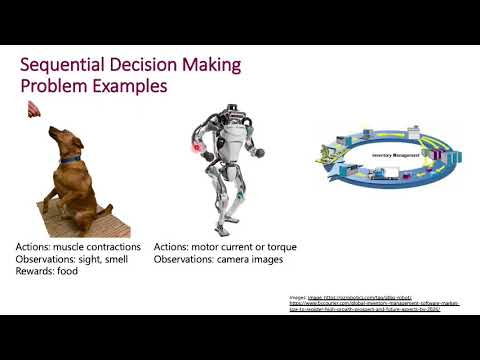

In [ ]:
#@title Video : Markov Decision Processes
try: t1;
except NameError: t1=time.time()

video = YouTubeVideo(id="GJEL-QkT2yk", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


We begin our study of reinforcement learning with a definition of  Markov decision process. A Markov decision process (MDP) is a tuple $(S, A, P, R, \gamma)$, where

- $S$ is the set of **states**.
- $A$ is the set of **actions**.
- $P$ defines the **transition probablities**. $P(s'|s, a)$ gives the probability of transitioning to state $s'$ by taking action $a$ at state $s$. 
- $R$ is the **reward function**. $R(s, a)$ gives the reward of taking action $a$ at state $s$. $R$ can also be a function of state only.
- $\gamma$ is the **discount factor**. It controls how much future rewards matter to us. We will talk more about discount factor in the next video.

As an aside, we introduce partially observable MDP (POMDP). A POMDP additionally has a set of obervations $O$ and emission probabilities $\varepsilon$. $\varepsilon(o|s)$ gives the probability of observing $o$ at state $s$. This formulation is useful when we don't have access to explicit state information, but are provided with observations that may not fully reveal the underlying states. An example is reinforcement learning from images.



## Section 2.2 Solving MDPs

Video available at https://youtube.com/watch?v=meywaLPitZ4


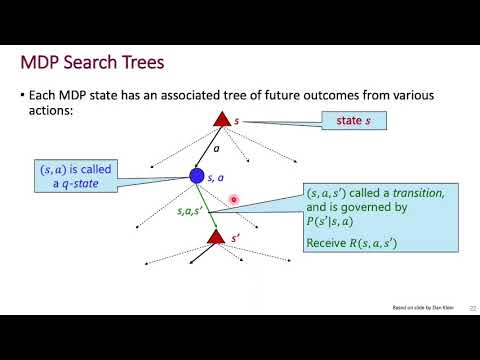

In [ ]:
#@title Video : Solving MDPs

video = YouTubeVideo(id="meywaLPitZ4", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


A policy $\pi: S ↦ A$ is a function representing a distribution mapping states to actions. At state $s$, we sample an action $a$ from the distribution $\pi(a|s)$ to execute in the environment. If all probability mass is assigned to one action, then the policy is deterministic. The goal of reinforcement learning is to find an optimal policy $\pi^*$ that maximizes the expected sum of discounted rewards: $$J_{\pi} = E_{\pi}\left[\sum_{t=0}^{\infty}\gamma^tR(s_t, a_t)\right]$$

Note that this objective assumes a continuous task, i.e. that $t$ extends to infinity. We can generalize it to episodic tasks with finite horizons by replacing $\infty$ with task horizon $T$. We may also discard the discount factor $\gamma$ in an episodic task.

## Section 2.3: Bellman Equations




Video available at https://youtube.com/watch?v=tm39P5jT320


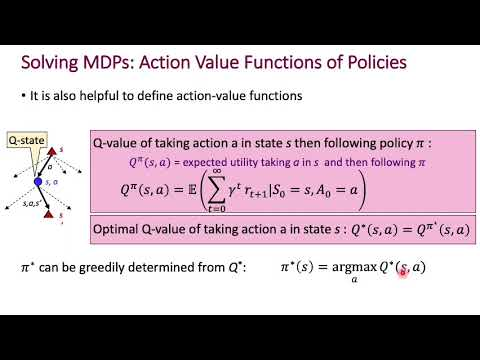

In [ ]:
#@title Video : V, Q, and the Bellman Equation
try: t2;
except NameError: t2=time.time()

video = YouTubeVideo(id="tm39P5jT320", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video



```
# This is formatted as code
```

We define the value of a state $s$ under policy $\pi$ as the expected future reward for following $\pi$ starting from $s$, $$V^{\pi}(s) = E_{\pi} \left[\sum_{t'=t}^{\infty} \gamma^{t'-t}R(s_{t'}, a_{t'}) \mid s_t = s\right] .$$

We further define the value of a state-action pair $(s, a)$ under policy $\pi$ as the expected future reward for taking action $a$ at state $s$, *and then* following $\pi$. This is also known as the Q-value $$Q^{\pi}(s, a) = E_{\pi} \left[\sum_{t'=t}^{\infty} \gamma^{t'-t}R(s_{t'}, a_{t'}) \mid s_t = s, a_t = a\right].$$

Observe that $V$ and $Q$ can be related by a simple equation:
$$V^{\pi}(s) = E_{a\sim \pi(a|s)}\left[Q^{\pi}(s, a)\right]$$

By definition, $V$ and $Q$ satisfy the following Bellman equations.

\begin{align*}
V^{\pi}(s) &= E_{a \sim \pi(a|s)}\left[R(s, a)+ \gamma E_{s' \sim P(s'|s, a)} \left[V^{\pi}(s')\right]\right] \\
Q^{\pi}(s, a) &= R(s, a) + \gamma E_{s' \sim P(s'|s, a)}\left[ E_{a' \sim \pi(a'|s')}\left[Q(s', a')\right]\right]
\end{align*}

The optimal value function $V^*$ captures the expected future reward if we start from state $s$ and act optimally in the future. Similarly, the optimal Q-function $Q^*$ captures the expected future reward if we start from state $s$, take action $a$, and then act optimally in the future. They satisfy the Bellman optimality equations:   

\begin{align*}
V^*(s) &= \max_{a\in A}\left(R(s, a) + \gamma E_{s' \sim P(s'|s, a)} \left[V^*(s')\right]\right)\\
Q^*(s, a) &= R(s, a) + \gamma E_{s' \sim P(s'|s, a)} \left[ \max_{a' \in A} Q^*(s', a')\right]
\end{align*}

If we have learned the optimal value function $V^*$ or Q-function $Q^*$, we can infer an optimal (deterministic) policy known as the greedy policy or argmax policy: $$\pi(s) = \arg\max_{a\in A}Q^*(s, a)$$

---
# Section 3: Gridworld


Before we dive into RL algorithms, let's get familiar with the running example we will use throughout this tutorial -- the Gridworld environment. As its name suggests, the Gridworld environment is an $m \times n$ grid. The states are x-y coordinates in the grid, with origin at the top-left corner. The agent starts from the initial state and aims to reach the terminal state. There are four actions: up, left, down, and right. Each action leads to a **deterministic** transition to the adjacent cell in the correspond direction (i.e. $P(s'|s, a) = 1$). By default, a reward of -1 is issued for entering any non-terminal state, although our implementation allows you to define an arbitrary reward for each state. 

To be more specific, our implementation admits four special cells: 'S' (start), 'T' (terminal), 'C' (cliff), and '#' (block). They are colored blue, green, red, and gray respectively. The agent spawns at the start cell, and aims to reach the terminal cell. If the agent "falls off the cliff," it will get a high penalty (-100) and be sent back to the start cell. If the agent tries to enter a block cell or go out of the grid, it will instead stay at the same place and get a reward of -1. 

Familiarize yourself with the environment's interface by interacting with the following code cells. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


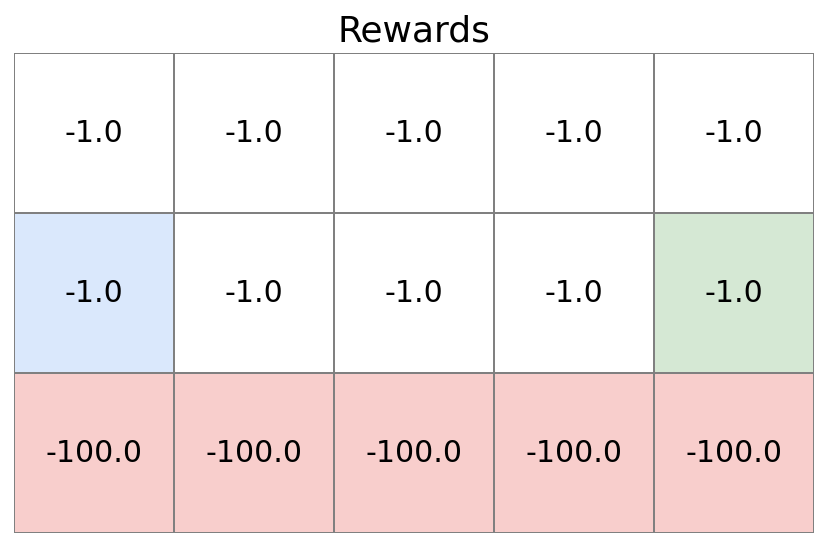

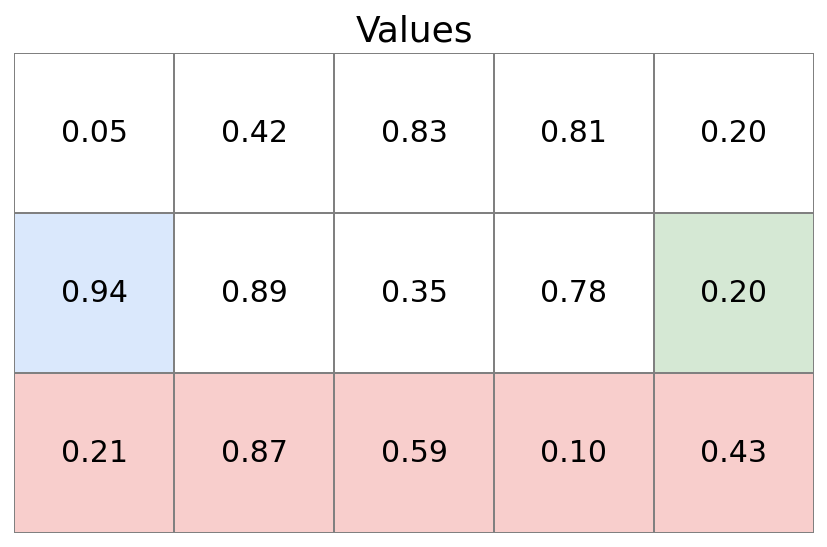

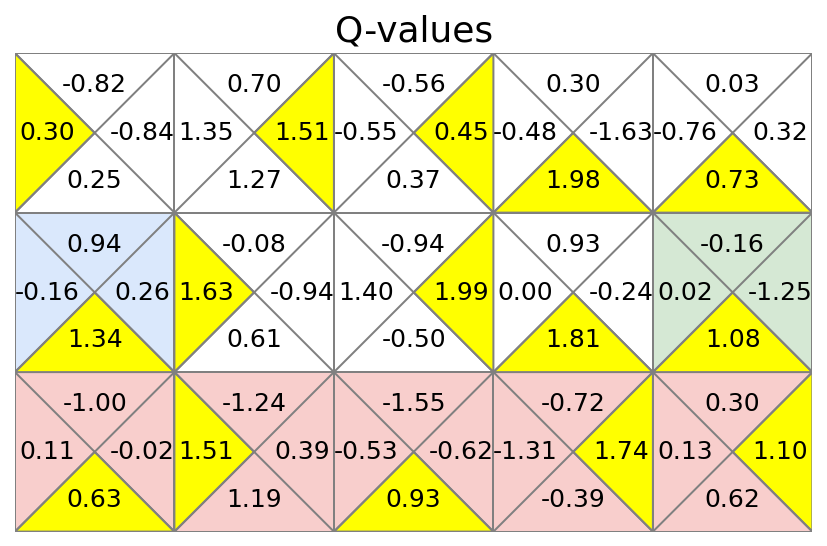

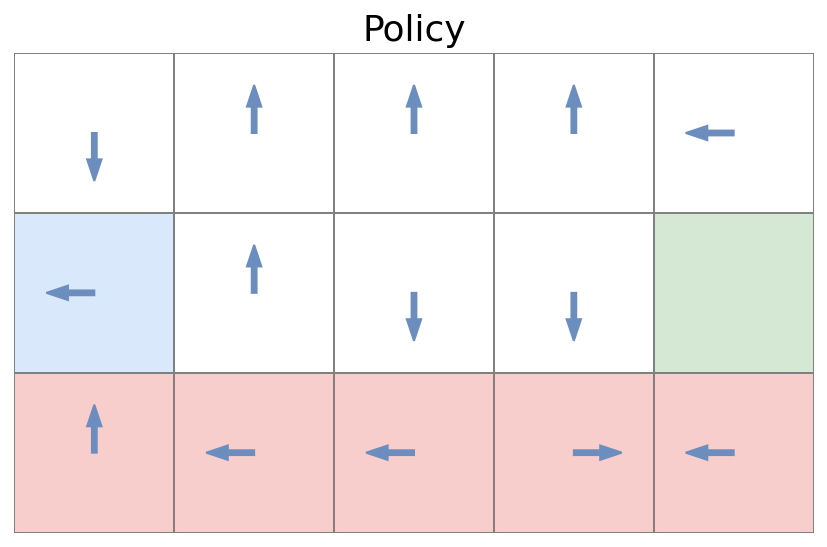

In [ ]:
# Get a pre-defined grid
gw = get_cliff_small()

# Render rewards 
gw.render_grid()

# Render random values
values = np.random.rand(4, 12)
gw.render_values(values)

# Render random Q-values and argmax policy
q_values = np.random.randn(4, 12, 4)
gw.render_q_values(q_values)

# Render random policy
policy = np.random.choice(4, (4, 12)).astype(int)
gw.render_policy(policy)

In our Gridworld environment, states are represented by a tuple (x, y), and actions are encoded as 0, 1, 2, 3, corresponding to up, left, down, right. `reset()` resets the agent to its initial state and returns the initial state. `step(action)` executes an action in the environment. It returns the agent's next state, the reward, and a boolean value indicating whether or not the terminal state is reached. In the following cell, control the agent to reach the terminal state.

In [ ]:
action_space = ['up', 'left', 'down', 'right']
def gw_step(gw, a):
    next_state, reward, done = gw.step(a)
    print(f'You moved {action_space[a]} to {next_state}, reward: {reward}, terminal state reached: {done}')

print(f"Initial state: {gw.reset()}") # reset to initial state
gw_step(gw, 0) # move up
gw_step(gw, 2) # move down

# Use gw_step() to reach the terminal state.


Initial state: (0, 1)
You moved up to (0, 0), reward: -1.0, terminal state reached: False
You moved down to (0, 1), reward: -1.0, terminal state reached: False


A useful method of the `Gridworld` class is `get_transition(state, action)`. It takes in a state and an action and returns the next state and the reward. We will use this function for exercises 1-3 where we assume full knowledge of the environment's transitions. In a reinforcement learning setting, we only have access to `step(action)`.

In [ ]:
# Show next state and reward for each action at state (0, 1)
print(gw.get_transition((0, 1), 0))
print(gw.get_transition((0, 1), 1))
print(gw.get_transition((0, 1), 2))
print(gw.get_transition((0, 1), 3))

((0, 0), -1.0)
((0, 1), -1.0)
((0, 1), -100.0)
((1, 1), -1.0)


---
# Section 4 Dynamic Programming

Video available at https://youtube.com/watch?v=l87rgLg90HI


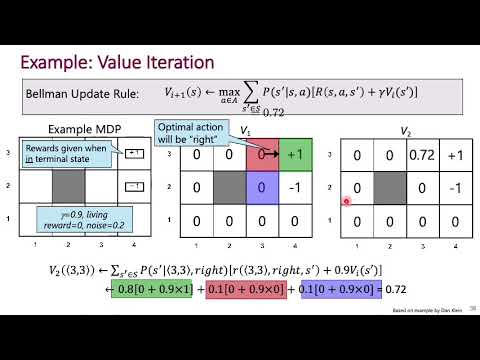

In [ ]:
#@title Video : Policy and Value Iteration
try: t3;
except NameError: t3=time.time()

video = YouTubeVideo(id="l87rgLg90HI", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Section 4.1: Policy Iteration

If we have full knowledge of the environment, in particular its transitions, we can use dynamic programming to find the optimal policy. The first algorithm we will study is policy iteration. We start with policy evaluation, which computes the value function of the policy using the Bellman equation. We iteratively perform Bellman backup for the value of each state until convergence: 
$$V(s) \leftarrow \sum_{a} \pi(a|s) \left(R(s, a) + \gamma\sum_{s'}P(s'|s, a)V(s')\right) $$
Since we have deterministic transitions, this simplifies to 
$$V(s) \leftarrow \sum_{a} \pi(a|s) \left(R(s, a) + \gamma V(s')\right)$$
where $s'$ is the state we transition to by taking action $a$ at state $s$. 

In the following excercise, you will evaluate a random policy which assigns equal probablities to all actions at each state. Complete one step of a Bellman backup. You can get the next state and reward using `grid.get_transition((x, y), action)`.


### Exercise 1

In [ ]:
# Random Policy evaluation
def random_policy_evaluation(grid, gamma=1.0):
    values = np.zeros_like(grid.rew_grid)
    iter = 0
    while True:
        eps = 0
        for y in range(grid.h):
            for x in range(grid.w):
                v = values[y, x]
                new_v = 0
                for action in range(grid.n_actions):
                     ###########################################################
                     # Fill in missing code below (...),
                     # then remove or comment the line below to test your function
                     raise NotImplementedError("Random policy evaluation")
                     ###########################################################
                     (new_x, new_y), reward = grid.get_transition((x, y), action)
                     new_v += ...
                     
                values[y, x] = new_v
                eps = max(eps, abs(new_v - v))
        iter += 1
        if eps < 0.0001:
            print("Converged after {} iterations".format(iter))
            break
    return values

# # Uncomment to test
# grid = get_book_grid()
# values = random_policy_evaluation(grid)
# grid.render_values(values)

Now we move on to the policy iteration algorithm. Policy iteration consists of two steps: policy evaluation and policy improvement. We first evaluate the policy, and then use the new values to derive a better policy by selecting the greedy action at each state. These steps are repeated until convergence. For an analysis of the theoretical guarantees of policy iteration, see [this page](http://incompleteideas.net/book/first/ebook/node42.html).

In the following exercise, you will implement the policy iteration algorithm. For policy evaluation, note that we have a deterministic greedy policy, so there's no need to iterate over actions. The general backup rule becomes $$V(s) \leftarrow R(s, \pi(s)) + \gamma\sum_{s'} P(s'|s, \pi(s)) V(s')$$ and for our environment this is $V(s) \leftarrow R(s, \pi(s)) + \gamma V(s')$. For policy improvement, we do the same evaluation for all actions and store them in the action_values array, from which we derive the greedy policy. **Be careful when indexing into the value matrix**: `values[y, x]` stores the value of state (x, y).

### Exercise 2

In [ ]:
# Policy Iteration 
def policy_evaluation(grid, values, policy, gamma):
    while True:
        eps = 0
        for y in range(grid.h):
            for x in range(grid.w):
                v = values[y, x]
                (new_x, new_y), reward = grid.get_transition((x, y), policy[y, x])
                ################################################################
                # Fill in missing code below (...),
                # then remove or comment the line below to test your function
                raise NotImplementedError("Policy evaluation")
                ################################################################
                new_v = ...
                
                values[y, x] = new_v
                eps = max(eps, abs(new_v - v))
        if eps < 0.0001: 
            break

def policy_improvement(grid, values, policy, gamma):
    converged = True
    for y in range(grid.h):
        for x in range(grid.w):
            old_action = policy[y, x]
            action_values = np.zeros(grid.n_actions, dtype=np.float)
            ####################################################################
            # Fill in missing code below (...),
            # then remove or comment the line below to test your function
            raise NotImplementedError("Policy improvement")
            ####################################################################
            for action in range(...):
                (new_x, new_y), reward = grid.get_transition((x, y), action)
                action_values[action] = ...
            policy[y, x] = ...

            if old_action != policy[y, x]:
                converged = False
    return converged

def policy_iteration(grid, gamma=0.9):
    policy = np.random.choice(grid.n_actions, (grid.h, grid.w)).astype(int)
    values = np.zeros_like(grid.rew_grid)
    converged = False
    while not converged:
        print("running policy evaluation")
        policy_evaluation(grid, values, policy, gamma)
        print("running policy improvement")
        converged = policy_improvement(grid, values, policy, gamma)
    return values, policy

# # Uncomment to test
# grid = get_book_grid()
# values, policy = policy_iteration(grid)
# grid.render_values(values)
# grid.render_policy(policy)

## Quiz Question 1

Construct the path from the policy visualization and see that following the policy from the initial state indeed leads to terminal state. Now change $\gamma$ to 1.0 and rerun the code. Does policy iteration still converge? Why are we stuck on policy evaluation? (This is a brain-teaser, so don't spend too much time on it, and don't let the code run for too long.)

In [ ]:
convergence = '' #@param {type:"string"}

## Section 4.2: Value Iteration

Value iteration can be thought of as a simplification of policy iteration, where we effectively combine the two steps in policy iteration into one. We still iterate over all states, but in each iteration the value update becomes $$V(s) \leftarrow \max_a R(s, a) + \gamma\sum_{s'}P(s'|s, a)V(s') $$ So instead of computing the state value and then selecting the greedy action, we directly store the maximum state-action value. This obviates the need to maintain an explicit policy. After the value matrix has converged, we can back out the optimal policy by taking the argmax, same as what we did in policy improvement.

Now it's your turn to implement the value iteration algorithm. You need to fill in the new update rule, and copy your code from policy improvment to reconstruct the optimal policy.

### Exercise 3

In [ ]:
# Value Iteration

def value_iteration(grid, gamma=0.9):
    V = np.zeros_like(grid.rew_grid)
    while True:
        eps = 0
        for y in range(grid.h):
            for x in range(grid.w):
                v = values[y, x]
                action_values = np.zeros(grid.n_actions)
                ################################################################
                # Fill in missing code below (...),
                # then remove or comment the line below to test your function
                raise NotImplementedError("Value iteration")
                ################################################################
                for action in range(...):
                    (nx, ny), reward = grid.get_transition((x, y), action)
                    action_values[action] = ... 
                new_v = ...
                
                values[y, x] = new_v
                eps = max(eps, abs(new_v - v))
        if eps < 0.0001:
            break

    # Create greedy policy from values
    policy = np.zeros_like(grid.rew_grid).astype(int)
    for y in range(grid.h):
        for x in range(grid.w):
            action_values = np.zeros(grid.n_actions)
            ####################################################################
            # Copy your solution for policy improvement here
            raise NotImplementedError("Value iteration policy")
            #################################################################### 
            for action in range(...):
                (nx, ny), reward = grid.get_transition((x, y), action)
                action_values[action] = ...
            policy[y, x] = ...

    return values, policy

# # Uncomment to test
# grid = get_book_grid()
# values, policy = value_iteration(grid)
# grid.render_values(values)
# grid.render_policy(policy)

---
# Section 5: Temporal Difference (TD) Learning



Video available at https://youtube.com/watch?v=rCk_hvwZ6iA


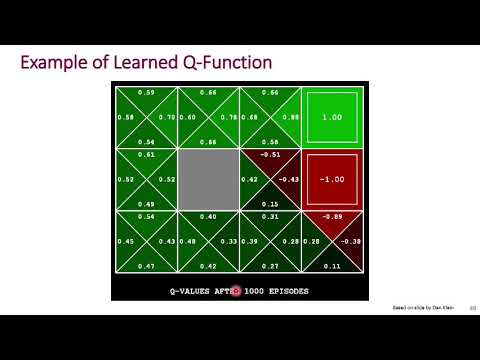

In [ ]:
#@title Video : TD and Q Learning
try: t4;
except NameError: t4=time.time()

video = YouTubeVideo(id="rCk_hvwZ6iA", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Section 5.1 Q-learning

Up until now we have assumed full access to the transitions of an environment. But in a typical reinforcement learning problem the dynamics is unknown. So how do we solve it? One way is to learn to approximate the dynamics using a function approximator (e.g. a neural net) and then apply dynamic programming or trajectory optimization. This is called model-based reinforcement learning, which we will cover next week. In this tutorial, we will study algorithms in the model-free regime. Specifically, we will investigate **Temporal Difference (TD) learning**.

The idea behind TD learning is to use $V(s_{t+1})$ as an imperfect proxy for the true value (Monte Carlo bootstrapping), and obtain a generalized equation to calculate the TD error:
$$\delta_t = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)$$

The expression $r_{t+1} + \gamma V(s_{t+1})$ is also called the TD target. We can then update the value using a learning rate $\alpha$.
$$ V(s_t) \leftarrow V(s_t) + \alpha \delta_t$$

**Q-learning** is an instantiation of TD learning, where the TD error is $$\delta_t = R(s_t, a_t) + \gamma \max_{a} Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)$$ and the full update rule is $$Q(s_t,a_t) \leftarrow Q(s_t, a_t) + \alpha \left(R(s_t, a_t) + \gamma \max_{a} Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)\right)$$

Because of the max operator used to select the optimal Q-value in the TD target, Q-learning directly estimates the optimal action value, i.e. the cumulative future reward that would be obtained if the agent behaved optimally, regardless of the policy currently followed by the agent. For this reason, Q-learning is referred to as an **off-policy** method. A sketch of the Q-learning algorithm is as follows:

```
for n episodes:
    for T steps:
        Select an action a_t using some policy derived from the current Q-values
        Execute a_t in the environment to get reward r and next state s_{t+1}
        Update Q(s_t, a_t) using (s_t, a_t, r, s_{t+1})
```

A remaining question is, how do we select an action base on the current Q-values? If the approximated Q-values are very bad, then greedily following the argmax policy may cause the agent to get stuck in some bad states. Thus, we instead adopt an **epsilon-greedy policy**, where we choose the argmax action with probability $(1-\epsilon)$ and take a random action otherwise. This relates to an important concept in reinforcement learning, namely exploration vs. exploitation. 

In [ ]:
# Epsilon-greedy policy
def epsilon_greedy(q_values, epsilon):
    if np.random.random() > epsilon:
        action = np.argmax(q_values)
    else:
        action = np.random.choice(len(q_values))
    return action

# General TD learning algorithm
def learn_gridworld(env, backup_rule, params, max_steps, n_episodes):
    values = np.zeros((env.h, env.w, env.n_actions))
    episode_actions = []
    episode_rewards = np.zeros(n_episodes)

    for episode in tqdm(range(n_episodes)):
        env.reset()
        total_reward = 0
        action_list = []

        for t in range(max_steps):
            state = env.state
            # Select action from epsilon-greedy policy
            action = epsilon_greedy(values[state[1], state[0]], params['epsilon'])
            action_list.append(action)
            # Execute action
            next_state, reward, done = env.step(action)
            # Update values
            values = backup_rule(state, action, reward, next_state, values, params)
            total_reward += reward
            if done:
                break
        
        episode_actions.append(action_list)
        episode_rewards[episode] = total_reward

    return values, episode_rewards

### Exercise 4

In this exercise, you will implement the update rule for Q-learning and test it on the Cliff World environment, where the agent needs to navigate to the other side of the cliff without falling off. You need to fill in the code for computing the TD error and updating the values matrix.

In [ ]:
# Q-Learning
def q_learning_backup(state, action, reward, next_state, values, params):
    '''
    Compute a new set of q-values using the q-learning update rule.
    Args:
        state (tuple): s_t, a tuple of xy coordinates.
        action (int): a_t, an integer from {0, 1, 2, 3}.
        reward (float): the reward of executing a_t at s_t.
        next_state (tuple): s_{t+1}, a tuple of xy coordinates.
        values (ndarray): an (h, w, 4) numpy array of q-values. values[y, x, a] 
                          stores the value of executing action a at state (x, y).
        params (dict): a dictionary of parameters.

    Returns:
        ndarray: the updated q-values.
    '''
    x, y = state
    nx, ny = next_state
    gamma = params['gamma']
    alpha = params['alpha']

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Q-learning")
    ####################################################################
    q = ...
    max_next_q = ...

    # Compute TD error using q and max_next_q
    td_error = ...
    values[y, x, action] = ...

    return values

# # Uncomment to test
# env = get_cliff_walk()
# params = {'gamma': 1.0, 'alpha': 0.1 , 'epsilon': 0.1}
# max_steps = 1000
# n_episodes = 500
# q_values, episode_rewards = learn_gridworld(env, q_learning_backup, params, max_steps, n_episodes)

# plot_episode_rewards(episode_rewards)
# env.render_policy(np.argmax(q_values, axis=2))
# env.render_q_values(q_values)

## Section 5.2: SARSA

An alternative to Q-learning, the SARSA algorithm also estimates action values. However, rather than estimating the optimal (off-policy) values, SARSA estimates the **on-policy** action values, i.e. the cumulative future reward that would be obtained if the agent behaved according to its current beliefs.

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(R(s_t, a_t) + \gamma Q(s_{t+1}, \pi(s_{t+1})) - Q(s_t,a_t)\big)
\end{align}

In fact, you will notices that the *only* difference between Q-learning and SARSA is the TD target calculation uses the policy to select the next action (in our case epsilon-greedy) rather than using the action that maximizes the Q-value. You do not need to implement the SARSA algorithm. Run the following code cell and compare with Q-learning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  0%|          | 0/500 [00:00<?, ?it/s]

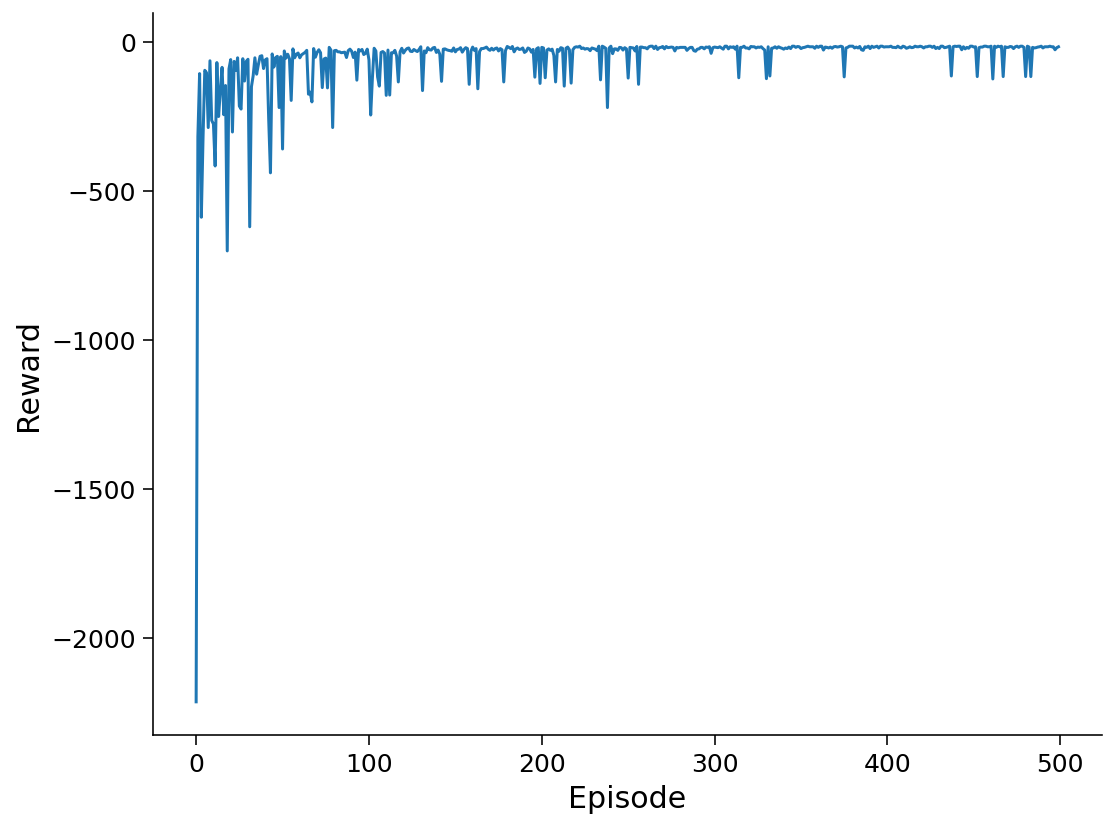

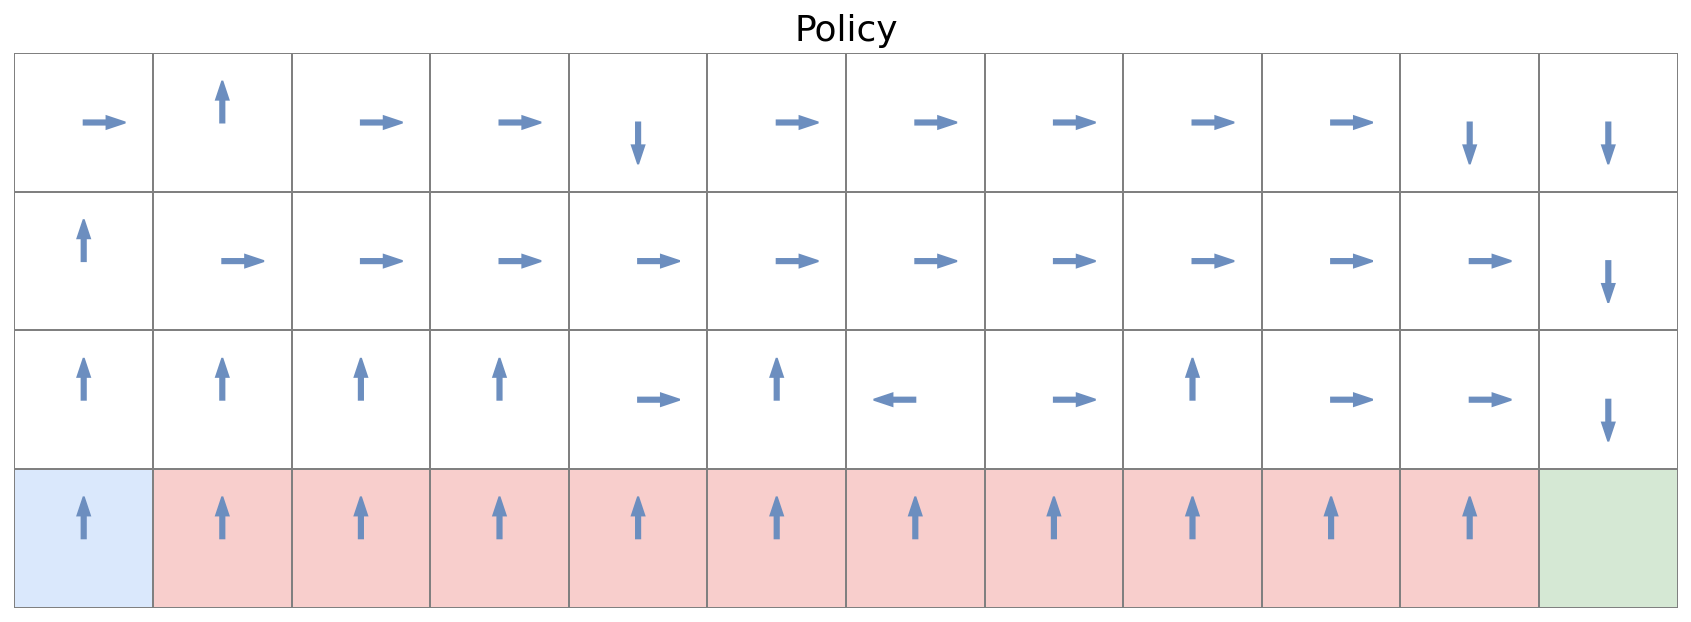

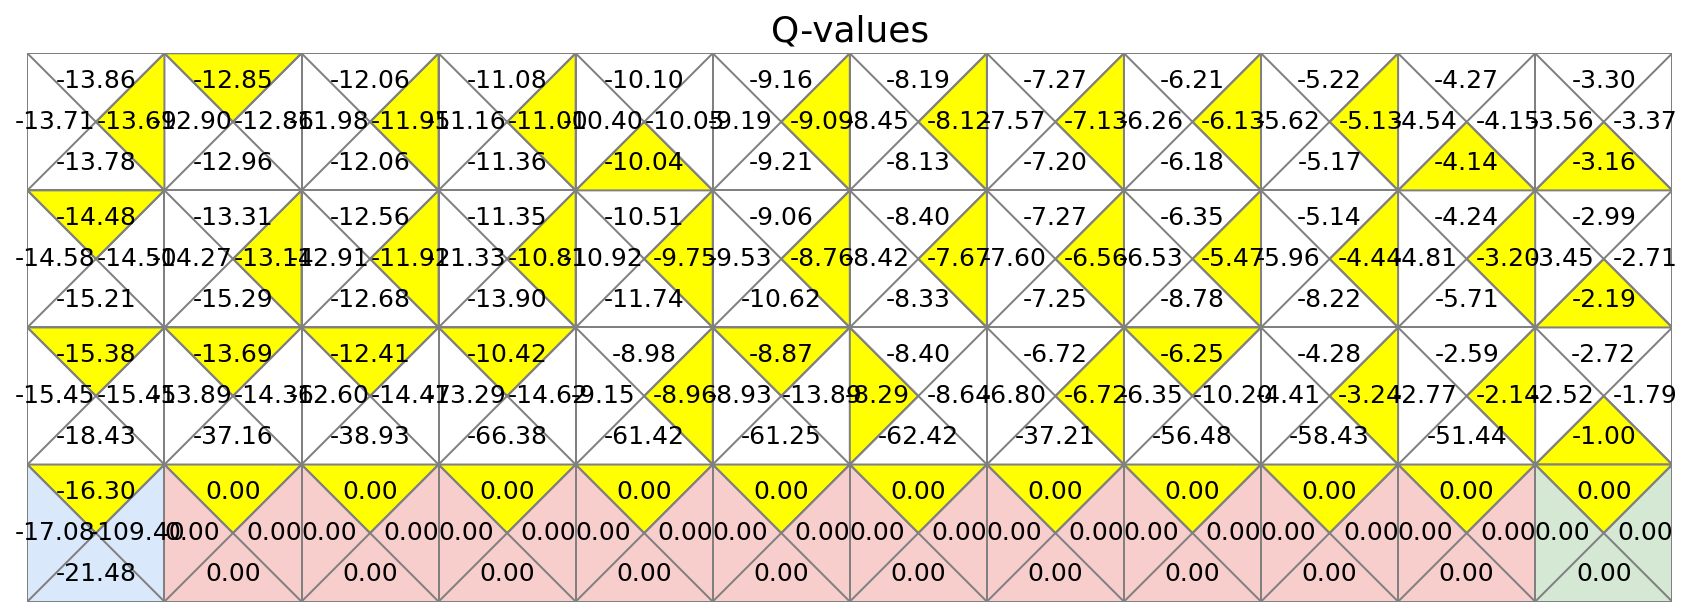

In [ ]:
# SARSA
def sarsa_backup(state, action, reward, next_state, values, params):
    '''
    Compute a new set of q-values using the SARSA update rule.
    Args:
        state (tuple): s_t, a tuple of xy coordinates.
        action (int): a_t, an integer from {0, 1, 2, 3}.
        reward (float): the reward of executing a_t at s_t.
        next_state (tuple): s_{t+1}, a tuple of xy coordinates.
        values (ndarray): an (h, w, 4) numpy array of q-values. values[y, x, a] 
                          stores the value of executing action a at state (x, y).
        params (dict): a dictionary of parameters.

    Returns:
        ndarray: the updated q-values.
    '''
    x, y = state
    nx, ny = next_state
    gamma = params['gamma']
    alpha = params['alpha']

    q = values[y, x, action]
    # Obtain on-policy action 
    policy_action = epsilon_greedy(values[ny, nx], params['epsilon'])
    next_q = values[ny, nx, policy_action]

    # Compute TD error using q and max_next_q
    td_error = reward + (gamma * next_q - q)
    values[y, x, action] = q + alpha * td_error

    return values

env = get_cliff_walk()
params = {'gamma': 1.0, 'alpha': 0.1 , 'epsilon': 0.1}
max_steps = 1000
n_episodes = 500
q_values, episode_rewards = learn_gridworld(env, sarsa_backup, params, max_steps, n_episodes)

plot_episode_rewards(episode_rewards)
env.render_policy(np.argmax(q_values, axis=2))
env.render_q_values(q_values)

---
# Wrap-up

In [1]:
#@markdown #Run Cell to Show Airtable Form
#@markdown Confirm your answers and then click "Submit". If you're having any issues, fill out the form here: https://airtable.com/shrPJU1XCLB9Lstgb.

import time
import numpy as np
import urllib.parse
from IPython.display import IFrame
def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()

# autofill fields if they are not present
# a missing pennkey and pod will result in an Airtable warning
# which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: my_email;
except NameError: my_email = ""
try: convergence;
except NameError: convergence = ""



times = np.array([t1])-t0

fields = {
    "pennkey": my_pennkey,
    "pod": my_pod, 
    "email": my_email, 
    "convergence": convergence,
    "cumulative_times": times
}

src = "https://airtable.com/embed/shrPJU1XCLB9Lstgb?"

display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))


## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shr1TzujOOOY21kFQ">https://airtable.com/shr1TzujOOOY21kFQ</a>

In [ ]:
# @title Feedback form
display(IFrame(src="https://airtable.com/embed/shr1TzujOOOY21kFQ", width = 800, height = 400))